# Select Sampling Method
We have several routes for producing new structures:
1. Molecular dynamics (MD), which does not intentionally create unrealistic structures
2. Monte Carlo Thermal Basin Paving (MCTBP), which creates unrealistic structures by perturbing the atomic positions of a water at the beginning of each step
3. Minima Hoping Method (MHM), which is somewhere between those two
Arguments can be made for both "unrealistic" structures being key for training because they ensure the model is taught to avoid them,
or deterimental because they induce a model to waste learning capacity in regions that should never be sampled.
Our goal here is to bypass theory and just measure which performs better.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import utils
import json

## Load in Examples
We only vary the sampling method, keeping the number of structures produced and the target error constant.
We selected a target error of 2.5 meV/atom because it gave us a model that performed well against a hold-out set and produced better structure when used for MCTBP.

In [2]:
runs = list(Path('../prod-runs/').glob('ttm_*-3000_thr-0.001'))
print(f'Found {len(runs)} runs')

Found 3 runs


Make sure training parameters for the network were the same

In [3]:
params = json.loads((runs[0] / 'final-model' / 'params.json').read_text())
params.pop('run_dir')
for run in runs:
    duplicates = json.loads((run / 'duplicates.json').read_text())
    for dup in duplicates:
        dup = Path(dup)
        my_params = json.loads((dup / 'final-model' / 'params.json').read_text())
        my_params.pop('run_dir')
        assert my_params == params, f'{dup} is different than {runs[0]}. {params} != {my_params}'

## Compare Against Hold-out Set
Using the same procedure as last notebook

In [4]:
data = utils.assess_against_holdout(runs, ['sampling_method'])

We now have the errors and for each error tolerance

In [5]:
data

,sampling_method,n_duplicates,energy_error_per_atom-mean,energy_error_per_atom-sem,force_rmsd-mean,force_rmsd-sem,energy_error_per_atom-init-mean,energy_error_per_atom-init-sem,force_rmsd-init-mean,force_rmsd-init-sem
0,mctbp,3,2.030405,0.067306,0.320491,0.007675,0.611805,0.014869,0.295862,0.004432
1,md,1,0.513566,0.023117,0.141537,0.003034,0.611805,0.025899,0.295862,0.007720
2,mhm,3,1.655311,0.036627,0.329508,0.007849,0.611805,0.014869,0.295862,0.004432


Make a figure

Text(0.5, 0, 'Sampling Method')

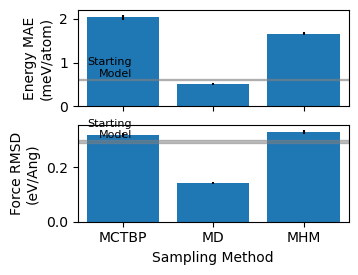

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.75))

axs[0].set_xlim([-0.5, 2.5])
for ax, t in zip(axs, ['energy_error_per_atom', 'force_rmsd']):
    # Plot the initial model
    ax.bar(range(3), data[f'{t}-mean'], yerr=data[f'{t}-sem'])
    
    # Plot the initial model
    row = data.iloc[0]
    ax.fill_between(ax.get_xlim(),
                    y1=row[f'{t}-init-mean'] + row[f'{t}-init-sem'],
                    y2=row[f'{t}-init-mean'] - row[f'{t}-init-sem'],
                   color='gray', alpha=0.5)
    ax.text(0.1, row[f'{t}-init-mean'] + row[f'{t}-init-sem'], 'Starting\nModel',
           ha='right', va='bottom', fontsize=8)
    
axs[-1].set_xticks(range(3))
axs[-1].set_xticklabels(data['sampling_method'].str.upper())
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[-1].set_xlabel('Sampling Method')

## Repeat with MCTBP
See if the sampling methods improve performance

In [7]:
data = utils.assess_from_mctbp_runs(runs, ['sampling_method'])

Summarize all runs

In [8]:
data

,sampling_method,n_duplicates,number_sampled,energy_error-mean,energy_error-sem,force_error-mean,force_error-sem,max_force-mean,max_force-sem,tau-mean,tau-sem
0,mctbp,3,4750,76.953050,1.176458,8.933284,0.094050,3.888127,0.036909,0.197511,0.053553
1,md,1,1540,33.545950,0.934974,4.779817,0.106228,2.364543,0.055548,0.541316,0.042616
2,mhm,3,4726,129.809599,1.510801,11.695563,0.092506,4.675914,0.033375,-0.003762,0.042692


Plot the errors

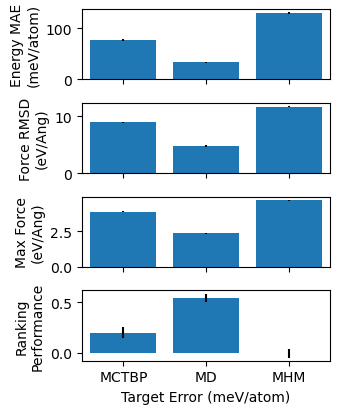

In [9]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3.5, 4.25))

axs[-1].set_xlim([-0.5, 2.5])
for ax, t in zip(axs, ['energy_error', 'force_error', 'max_force', 'tau']):
    ax.bar(range(3), data[f'{t}-mean'], yerr=data[f'{t}-sem'])
    
axs[-1].set_xticks(range(3))
axs[-1].set_xticklabels(data['sampling_method'].str.upper())
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[2].set_ylabel('Max Force\n(eV/Ang)')
axs[3].set_ylabel('Ranking\nPerformance')
axs[-1].set_xlabel('Target Error (meV/atom)')

fig.tight_layout()